In [1]:
import boto3

bedrock_client = boto3.client('bedrock', region_name='us-east-1')

response = bedrock_client.list_foundation_models()

llm_dict = {}
for obj in  response['modelSummaries']:
    llm_dict[obj['modelName']] = obj['modelId']

In [2]:
def llm(modelid: str):

    from langchain_aws import ChatBedrockConverse

    return ChatBedrockConverse(model_id=modelid, region_name='us-east-1')

In [3]:
from langchain_core.prompts import ChatPromptTemplate 

from langgraph.prebuilt import create_react_agent

from langchain_mcp_adapters.client import MultiServerMCPClient

from dotenv import load_dotenv

import os

load_dotenv('/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/.env')

client = MultiServerMCPClient(
    {
        "mcp_tools": {
            
            "url": os.getenv('MCP_URL'),
            "transport": "sse"
        }
    }
)

prompt = ChatPromptTemplate([
    ('system','You are a statistics agent.\n\n'
    'INSTRUCTIONS:\n'
    '- Assist ONLY with statistics-related tasks, DO NOT do any thing else\n'
    '- After you are done with your tasks, respond to the supervisor directly\n'
    '- Respond ONLY with the results of your work, do not include ANY other text.'),
    ('placeholder', '{messages}')  
])


search_tool = await client.get_tools()

tool = None
for obj in search_tool:
    if obj.name=='google_search_tool':
        tool = obj
        break

statistics_agent = create_react_agent(llm(llm_dict['Claude 3.5 Sonnet']), tools=[tool], prompt=prompt, name='statistics_agent')

In [4]:
from langchain_core.messages import convert_to_messages
# clean output from web

def clean_print_msg(message, indent=False):
    clean_message = message.pretty_repr(html=True)
    if not indent:
        print(clean_message)
        return

    indented = '\n'.join('\t' + c for c in clean_message.split('\n'))
    print(indented)

def clean_print_msgs(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return
        
        graph_id = ns[-1].split(':')[0]
        print(f'Update from subgraph {graph_id}:')
        print('\n')
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f'Update from node {node_name}:'
        if is_subgraph:
            update_label = '\t' + update_label
        print(update_label)
        print('\n')

        messages = convert_to_messages(node_update['messages'])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            clean_print_msg(m, indent=is_subgraph)
        print('\n')

In [5]:
import asyncio
query = 'Provide an explination of What normality is'

async for chunk in statistics_agent.astream({'messages':['user', query]}):
    clean_print_msgs(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: statistics_agent

[{'type': 'text', 'text': "To provide an up-to-date and accurate explanation of normality in statistics, I'll need to search for recent information. Let me do that for you."}, {'type': 'tool_use', 'name': 'google_search_tool', 'input': {'query': 'statistical normality definition and explanation'}, 'id': 'tooluse_mRUFXcrkQouc--kvWc9ZeQ'}]
Tool Calls:
  google_search_tool (tooluse_mRUFXcrkQouc--kvWc9ZeQ)
 Call ID: tooluse_mRUFXcrkQouc--kvWc9ZeQ
  Args:
    query: statistical normality definition and explanation


Update from node tools:


================================= Tool Message =================================
Name: google_search_tool

{
  "results": [
    {
      "title": "Navigating Data Analysis: The Importance of Testing for Normality ...",
      "link": "https://www.isixsigma.com/dictionary/normality-test/",
      "snippet": "Feb 3, 2025 ... Norm

In [9]:
from langchain_core.tools import tool

import matplotlib.pyplot as plt

@tool
def gen_plot(plot_type: str = "line", title: str = "My Plot", x: list = [1, 2, 3], y: list = [1, 4, 9]) -> str:
    """Generate a plot using Matplotlib. Returns base64-encoded PNG string.
    
    Args:
        plot_type: 'line', 'bar', or 'scatter'
        title: title of the plot
        x: list of x values
        y: list of y values
    """
    plt.figure()
    if plot_type == "line":
        plt.plot(x, y)
    elif plot_type == "bar":
        plt.bar(x, y)
    elif plot_type == "scatter":
        plt.scatter(x, y)
    else:
        return f"Unsupported plot_type: {plot_type}"

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")

In [10]:
from langchain_core.prompts import ChatPromptTemplate 

from langgraph.prebuilt import create_react_agent

prompt = ChatPromptTemplate([
    ('system','You are a visualization agent.\n\n'
    'INSTRUCTIONS:\n'
    '- Assist ONLY with visualization-related tasks\n'
    '- After you are done with your tasks, respond to the supervisor directly\n'
    '- Respond ONLY with the results of your work, do not include ANY other text.'),
    ('placeholder', '{messages}')  
])

visualization_agent = create_react_agent(llm('us.'+llm_dict['Claude 3.7 Sonnet']), tools=[gen_plot], prompt=prompt, name='visualization_agent')

Update from node agent:


================================== Ai Message ==================================
Name: visualization_agent

[{'type': 'text', 'text': 'I\'ll create a line plot with the title "Sales Over Time" using the default x and y values since specific data points weren\'t provided.'}, {'type': 'tool_use', 'name': 'gen_plot', 'input': {'plot_type': 'line', 'title': 'Sales Over Time', 'x': [1, 2, 3], 'y': [1, 4, 9]}, 'id': 'tooluse_4yCsxM7RTum8Iy7i5pkpag'}]
Tool Calls:
  gen_plot (tooluse_4yCsxM7RTum8Iy7i5pkpag)
 Call ID: tooluse_4yCsxM7RTum8Iy7i5pkpag
  Args:
    plot_type: line
    title: Sales Over Time
    x: [1, 2, 3]
    y: [1, 4, 9]


Update from node tools:


================================= Tool Message =================================
Name: gen_plot

null


Update from node agent:


================================== Ai Message ==================================
Name: visualization_agent

[]




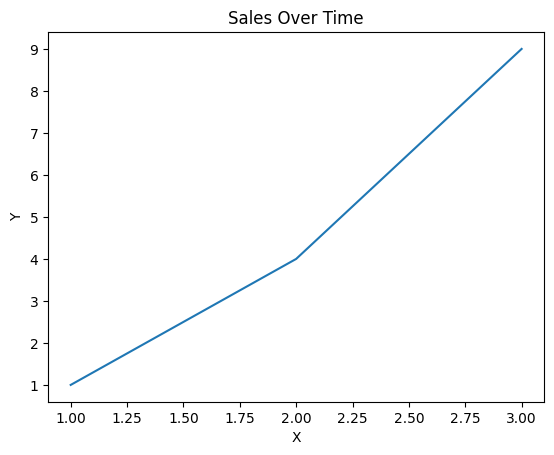

In [12]:
query = 'Please generate a line plot with the title "Sales Over Time. \n'
'The x-axis should be [1, 2, 3, 4, 5] representing months, and the y-axis should be [10, 20, 15, 30, 25] representing sales in thousands.'

for chunk in visualization_agent.stream({'messages':['user', query]}):
    clean_print_msgs(chunk)

In [13]:
from typing import Annotated

from langchain_core.tools import tool, InjectedToolCallId

from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def init_handoff_tool(*, agent_name: str, description: str | None=None):
    name = f'transfer_to_{agent_name}'
    description = description or f'Ask {agent_name} for help' 

    @tool(name, description=description)
    def handoff_tool(state: Annotated[MessagesState, InjectedState], tool_call_id: Annotated[str, InjectedToolCallId]) -> Command:
        tool_message = {
            'role':'tool',
            'content': f'Successfully transferred to {agent_name}',
            'name': name,
            'tool_call_id': tool_call_id}

        return Command(goto=agent_name, update={**state, 'messages':state['messages']+[tool_message]}, graph=Command.PARENT)
    return handoff_tool

    
assign_to_statistics_agent = init_handoff_tool(agent_name='statistics_agent', description='Assign task to a statistics agent.')
assign_to_visualization_agent = init_handoff_tool(agent_name='visualization_agent', description='Assign task to a visualization agent.')


In [14]:
from langgraph.prebuilt import create_react_agent

from langchain_aws import ChatBedrockConverse

from langchain_core.prompts import ChatPromptTemplate

llm = ChatBedrockConverse(model_id='us.'+llm_dict['Claude Sonnet 4'])

prompt = ChatPromptTemplate([
    ('system','You are a supervisor managing two agents\n\n'
    '- a research agent. Assign research-related tasks to this agent\n'
    '- a math agent. Assign math-related tasks to this agent\n'
    'Assign work to one agent at a time, do not call agents in parallel. \n'
    'Do not do any work yourself.'),
    ('placeholder', '{messages}')  
])

supervisor_agent = create_react_agent(model=llm, tools=[assign_to_visualization_agent, assign_to_statistics_agent], prompt=prompt, name='supervisor')

In [15]:
from langgraph.graph import END

supervisor = (
    StateGraph(MessagesState)
    .add_node(supervisor_agent)
    .add_node(statistics_agent)
    .add_node(visualization_agent)
    .add_edge(START, 'supervisor')
    .add_edge('statistics_agent', 'supervisor')
    .add_edge('visualization_agent', 'supervisor')
    .compile()
)

In [ ]:
### Dataset 
from sklearn.datasets import load_wine

data = load_wine()
# print(data.keys())

lbl = data['target_names']
header = [a+str(n) for n,a in enumerate(np.repeat('A',data['data'].shape[1]))]
df = pd.DataFrame(data['data'], columns=header)
df = df.iloc[:20,:]


In [ ]:
query = 'calcula'


for chunk in supervisor.stream({'messages':['user',query]}):
    clean_print_msgs(chunk, last_message=True)